# Qiskit & IBM Quantum Workshop



This tutorial was adapted from notebooks by: _Abby Mitchell - Quantum Developer Advocate (https://abbymitchell.dev) IBM Quantum_ and Qiskit tutorial documentations -: https://qiskit.org/documentation/tutorials.html

# How to Use this Notebook in your IBM Quantum Lab Account



1. Go to http://qisk.it/SGMeetupJul23 for the workshop resources

<img src="qr-code.png" width=300>

2. Click 'raw' button in GitHub, this will open the notebook file in a new tab

<img src="raw_button.png" width=600>

3. Right click on the raw file and save the file in jupyter notebook format (`.ipynb`)

<img src="save.png" width=600>

4. In IBM Quantum Lab, select upload button on in top left and upload the notebook file

<img src="upload_button.png" width=600>

5. If you didn't save it in `.ipynb` format you can rename the file in the jupyter lab

<img src="rename_button.png" width=600>

6. Now you can open the notebook in your IBM Quantum Lab environment! (note: if you want the images to display in your lab version you will need to download them from the github folder where the notebook is and upload it into your lab folder as well)

<img src="open_notebook.png" width=600>


# Goal: Show you the toolbox - Breadth, not depth!

### Contents:

- Welcome & About Me!


- Let's Explore IBM Quantum Labs, composer, services etc.


- What is Qiskit & the Qiskit Ecosystem


- NEW(ish)! Runtime Primitives (Qiskit & Qiskit Ecosystem)
  - [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html) (qiskit.primitives)
  - [IBM Qiskit Runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/)
  - QAOA Using Qiskit runtime

- What Next?


# Qiskit overview: Main Packages



![](qiskit_overview.png)





### Including the Ecosystem:
![](ecosystem.png)

## The Qiskit Ecosystem

https://qiskit.org/ecosystem

**Three Tiers:**
- Main
- Extensions
- Community

--> You can submit your open-source project to the Ecosystem!

What we'll focus on: mostly Qiskit (Terra)  
If we have time: other packages

# Primitives - New(ish) Feature 🎉



To understand Qiskit Runtime Primitives we need to take a trip down IBM Quantum memory lane...

![](circuit_flow.png)

![](runtime_prog_flow.png)

![](circ_runtime_comparison.png)

![](what_we_want.png)

![](primitives.png)

![](primitives_comparison.png)

![](sampler_estimator.png)


## Overview

Qiskit Runtime is a cloud-based quantum computing service developed by IBM. It offers computational *primitives* to perform foundational quantum computing tasks that utilize built-in error suppression and mitigation techniques. Primitives can be executed inside of *sessions*, allowing collections of circuits to be jointly run on a quantum computer without being interrupted by other users’ jobs. The combination of primitives, error suppression / mitigation, and sessions paves the way to efficiently build and execute scalable quantum applications.

The following figure illustrates how one can use Qiskit Runtime sessions and primitives. The first session request (job) waits through the regular `fair-share queue <https://quantum-computing.ibm.com/admin/docs/admin/manage/systems/queue>`__. When it starts to run, the session is started. After the first session job is finished processing, the next job in the session is run. This process continues until the session is paused (due to a lack of queued session jobs) or closed.

![](runtime-architecture.png)

### Key concepts

**Primitives**

Primitives are base level operations that serve as building blocks for many quantum algorithms and applications. Through these primitives, users can obtain high-fidelity results, without needing detailed hardware knowledge.  This abstraction allows you to write code, using Qiskit algorithms or otherwise, that can run on different quantum hardware or simulators without having to explicitly manage aspects such as compilation, optimization, and error suppression / mitigation. The primitives offered by `qiskit_ibm_runtime <https://qiskit.org/ecosystem/ibm-runtime/apidocs/ibm-runtime.html>`__ add additional options specific to IBM services. See `Introduction to primitives <primitives.html>`__ for further details.

There are currently two primitives defined in Qiskit: Estimator and Sampler.


**Estimator**

The estimator primitive allows you to efficiently calculate and interpret expectation values of quantum operators; the values of interest for many near-term quantum algorithms. You specify circuits that prepare quantum states and then Pauli-basis observables to measure on those states. The estimator can use advanced error suppression and mitigation capabilities to improve the accuracy of the returned expectation values.

**Sampler**

This primitive takes circuits as input and returns a quasi-probability distribution over the measurement outcomes. This generalizes histograms from quantum circuits, allowing for mitigation of readout errors.

**Error suppression / mitigation**

While building a fault-tolerant quantum computation is the ultimate goal, at present, calculations performed on near-term quantum computers are susceptible to noise.  Qiskit Runtime offers a number of methods for preventing errors before they occur (error suppression techniques) and dealing with those that do occur (error mitigation techniques).  

**Session**

A session allows a collection of jobs to be grouped and jointly scheduled by the Qiskit Runtime service, facilitating iterative use of quantum computers without incurring queuing delays on each iteration. This eliminates artificial delays caused by other users’ jobs running on the same quantum device during the session. See `Introduction to sessions <sessions.html>`__ for further details.


# Time for some code! (finally!)

## Simple Examples:

#### Simple Sampler Example

In [ ]:
from qiskit import QuantumCircuit

# Initialize quantum circuit
bell = QuantumCircuit(2,2)

# Apply gates
bell.h(0)
bell.cx(0,1)

# Measure qubits
bell.measure_all()

# Visualise circuit
bell.draw(output="mpl")

### Setting up runtime service

![](primitives_code.png)

In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

service = QiskitRuntimeService(channel="ibm_quantum",instance='ibm-q/open/main')

# Get the least busy backend, this step may take a while
simulator = "ibmq_qasm_simulator"

with Session(service, backend=simulator) as session:
    sampler = Sampler(session=session)
    job = sampler.run(bell)

In [8]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [16]:
job.result()

SamplerResult(quasi_dists=[{12: 0.511, 0: 0.489}], metadata=[{'shots': 4000}])

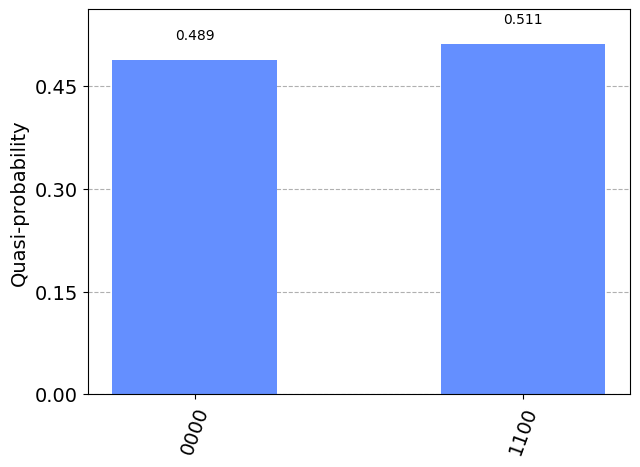

In [15]:
from qiskit.tools.visualization import plot_distribution

prob_distribution = job.result().quasi_dists[0].binary_probabilities()

plot_distribution(prob_distribution)

#### Use Primitives with IBM Devices via Sessions - (Alpha: Still under active development)

If you want to get results from IBM hardware using primitives, you need to use the `qiskit_ibm_runtime` provider, which facilitates the connection to the IBM hardware via sessions.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

service = QiskitRuntimeService(channel="ibm_quantum",instance='ibm-q/open/main')

# Get the least busy backend, this step may take a while
simulator = service.least_busy(min_num_qubits=2, simulator=False)

with Session(service, backend=simulator) as session:
    sampler = Sampler(session=session)
    job_real = sampler.run(bell)

In [ ]:
job.status()

### Simple Estimator Example

### 1. Initialize the account

Since Qiskit Runtime `Estimator` is a managed service, you will first need to initialize your account. You can then select the simulator or real backend you want to use to calculate the expectation value.

Follow the steps in the [getting started guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) if you don't already have an account set up.

In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", instance='ibm-q/open/main')
backend = service.backend("ibmq_qasm_simulator")

### 2. Create a circuit and an observable

Just like the section before, you will need at least one circuit and one observable as inputs to the `Estimator` primitive.

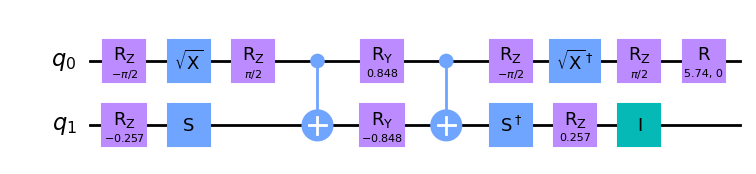

>>> Observable: ['XZ']


In [24]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

### 3. Initialize the Qiskit Runtime Estimator

Here we are initializing an instance of `qiskit_ibm_runtime.Estimator` rather than `qiskit.primitives.Estimator` to use Qiskit Runtime's implementation of the `Estimator`. 

When you initialize the `Estimator`, you'll need to pass in the backend you previously selected as the target device (or simulator), using the `backend` parameter.

In [25]:
from qiskit_ibm_runtime import Estimator

estimator = Estimator(backend=backend)

### 4. Invoke the Estimator and get results

You can then invoke the `run()` method to calculate expectation values for the input circuit(s) and observable(s).

In [26]:
job = estimator.run(circuit, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cimhvjllipn668clqptg
>>> Job Status: JobStatus.RUNNING


In [27]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> EstimatorResult(values=array([0.5]), metadata=[{'variance': 0.75, 'shots': 4000}])
  > Expectation value: 0.5
  > Metadata: {'variance': 0.75, 'shots': 4000}


# Options

Primitives come with several options that are grouped into different categories. Commonly used options, such as `resilience_level`, are at the first level.

![options](options.png)

You can use the [Options](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.options.Options.html#qiskit_ibm_runtime.options.Options) class to specify different options.

In the following example, we create an instance of the `Options` class. `optimization_level` is a first level option and can be passed as an input parameter. Options related to the execution environment are passed using the `environment` parameter.

In [28]:
from qiskit_ibm_runtime import Options

options = Options(optimization_level=3, environment={"log_level": "INFO"})

`Options` supports auto-complete. Once you create an instance of the `Options` class, you can use auto-complete to see what options are available. If you choose one of the categories, you can use auto-complete again to see what options are available under that category. 

In [29]:
from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 1
options.execution.shots = 2048

When creating an instance of the `Estimator` class, you can pass in the `options` you just created. Those options will then be applied when you use `run()` to perform the calculation. 

In [30]:
estimator = Estimator(backend=backend, options=options)
result = estimator.run(circuit, observable).result()
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'variance': 0.7361412048339844, 'shots': 2048, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}


You can also pass options to the `run()` method. This will overwrite the options you specified when creating the `Estimator` instance for that particular execution. 

Since most users will only overwrite a handful of options at the job level, it is not necessary to specify the category the options are in. The following code, for example, specifies `shots=1024` rather than `execution={"shots": 1024}` (which is also valid). 

In [31]:
estimator = Estimator(backend=backend, options=options)
result = estimator.run(circuit, observable, shots=1024).result()
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'variance': 0.7198448181152344, 'shots': 1024, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}


### Error suppression and mitigation

`optimization_level` and `resilience_level` are used to configure error suppress and mitigation.

`Estimator` supports `optimization_level` 0-3 and `resilience_level` 0-3.

Advanced mitigation options can be specified under `resilience`.

In [32]:
from qiskit_ibm_runtime import Options

# optimization_level=3 adds dynamical decoupling
# resilience_level=1 adds readout error mitigation
options = Options(optimization_level=3, resilience_level=1)

In [33]:
estimator = Estimator(backend=backend, options=options)
result = estimator.run(circuit, observable).result()
print(f">>> Expectation value: {result.values[0]}")
print(f">>> Metadata: {result.metadata[0]}")

>>> Expectation value: 0.4755
>>> Metadata: {'variance': 0.77389975, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}


# Session

A Qiskit Runtime _session_ allows you to group a collection of iterative calls to the quantum computer. A session is started when the first job within the session is started. If the session is active, subsequent jobs within the session are prioritized by the scheduler to minimize artificial delay within an iterative algorithm. Data used within a session, such as transpiled circuits, is also cached to avoid unnecessary overhead.

### Session timing

When a session is started, it is assigned a maximum session timeout value. You can set this value by using the `max_time` parameter.

If you don't specify a timeout value, it is set to the initial job's maximum execution time and is the smaller of these values:

- The system limit (see [What is the maximum execution time for a Qiskit Runtime job?](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/faqs/max_execution_time.html)).
- The `max_execution_time` defined by the program.

After this time limit is reached, the session is permanently closed.

A session also has an _interactive_ timeout value. If there are no session jobs queued within that window, the session is temporarily deactivated and normal job selection resumes. This interactive timeout value is set by the system and cannot be overwritten.

### Invoking Estimator.run within a session

You can create a Qiskit Runtime session using the context manager (`with ...:`), which automatically opens and closes the session for you. You can invoke `Estimator.run` one or more times within a session:

In [34]:
from qiskit_ibm_runtime import Session, Estimator

with Session(backend=backend, max_time="1h"):
    estimator = Estimator()

    result = estimator.run(circuit, observable).result()
    print(f">>> Expectation value from the first run: {result.values[0]}")

    result = estimator.run(circuit, observable).result()
    print(f">>> Expectation value from the second run: {result.values[0]}")

>>> Expectation value from the first run: 0.5145
>>> Expectation value from the second run: 0.5215


### Invoke multiple primitives in a session

You are not restricted to a single primitive function within a session. In this section we will show you an example of using multiple primitives. 

First we prepare a circuit for the sampler primitive.

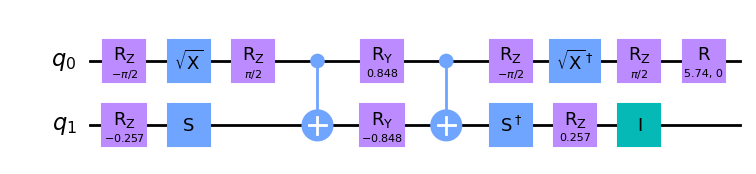

In [35]:
from qiskit.circuit.random import random_circuit

sampler_circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
sampler_circuit.measure_all()
display(circuit.draw("mpl"))

The following example shows how you can create both an instance of the `Sampler` class and one of the `Estimator` class and invoke their `run()` methods within a session. 

In [36]:
from qiskit_ibm_runtime import Session, Sampler, Estimator

with Session(backend=backend):
    sampler = Sampler()
    estimator = Estimator()

    result = sampler.run(sampler_circuit).result()
    print(f">>> Quasi-probability distribution from the sampler job: {result.quasi_dists[0]}")

    result = estimator.run(circuit, observable).result()
    print(f">>> Expectation value from the estimator job: {result.values[0]}")

>>> Quasi-probability distribution from the sampler job: {1: 0.02875, 3: 0.51275, 2: 0.04425, 0: 0.41425}
>>> Expectation value from the estimator job: 0.519


The calls can also be asynchronous. You don't need to wait for the result of a previous job before submitting another one. 

In [37]:
from qiskit_ibm_runtime import Session, Sampler, Estimator

with Session(backend=backend):
    sampler = Sampler()
    estimator = Estimator()

    sampler_job = sampler.run(sampler_circuit)
    estimator_job = estimator.run(circuit, observable)

    print(
        f">>> Quasi-probability distribution from the sampler job: {sampler_job.result().quasi_dists[0]}"
    )
    print(f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}")

>>> Quasi-probability distribution from the sampler job: {1: 0.0335, 3: 0.5255, 2: 0.0445, 0: 0.3965}
>>> Expectation value from the estimator job: 0.499


# Summary

The following code recaps using Qiskit Runtime primitives, options, and session.

In [24]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    Sampler,
    Estimator,
    Options,
)

# 1. Initialize account
service = QiskitRuntimeService(channel="ibm_quantum", instance='ibm-q/open/main')

# 2. Specify options, such as enabling error mitigation
options = Options(resilience_level=1)

# 3. Select a backend.
backend = service.backend("ibmq_qasm_simulator")

# 4. Create a session
with Session(backend=backend):
    # 5. Create primitive instances
    sampler = Sampler(options=options)
    estimator = Estimator(options=options)

    # 6. Submit jobs
    sampler_job = sampler.run(sampler_circuit)
    estimator_job = estimator.run(circuit, observable)

    # 7. Get results
    print(
        f">>> Quasi-probability distribution from the sampler job: {sampler_job.result().quasi_dists[0]}"
    )
    print(f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}")

>>> Quasi-probability distribution from the sampler job: {0: 0.49575, 2: 0.50425}
>>> Expectation value from the estimator job: 0.8315


# QAOA using Qiskit Runtime primitives and Session


## Background

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid iterative method for solving combinatorial optimization problems.  You can learn more about this algorithm [here](https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa).  In this tutorial we demonstrate how to implement the QAOA algorithm using Qiskit Runtime for solving a simple max-cut problem.


In a max-cut problem, we want to partition nodes of a graph in a way that maximizes the number of edges between nodes in differing groups. The desired max-cut partition for the graph below is clear: the 0th-node on the left should be separated from the rest of the nodes on the right by a cut. We will find this answer by applying QAOA by using Qiskit Runtime primitives and sessions. 

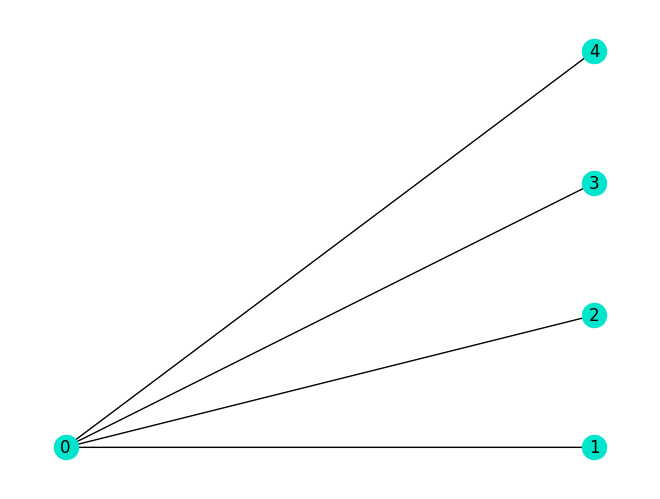

In [40]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#00e5cc")

## Setup

In [41]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

%config InlineBackend.figure_format='retina'

## Initialize Runtime service and select backend

First, we need to instantiate the IBM Quantum Runtime service `QiskitRuntimeService` in order to choose a [computational resource](https://quantum-computing.ibm.com/services/resources?tab=systems&limit=40) on which to execute our QAOA algorithm. In this tutorial, the `ibmq_qasm_simlator` is chosen.

In [44]:
service = service = QiskitRuntimeService(channel="ibm_quantum", instance='ibm-q/open/main')
backend = service.get_backend("ibmq_qasm_simulator")

## QAOA Hamiltonian and ansatz

To utilize QAOA algorithm for a max-cut problem we require a Pauli Hamiltonian that encodes the cost in a manner such that the minimum expectation value of the operator corresponds to the maximum number of edges between the nodes in two different groups.  

For this simple example, the operator is a linear combination of terms with `Z` operators on nodes connected by an edge (recall that the 0th qubit is farthest right): $IIIZZ + IIZIZ + IZIIZ + ZIIIZ$. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit from the Qiskit circuit library.

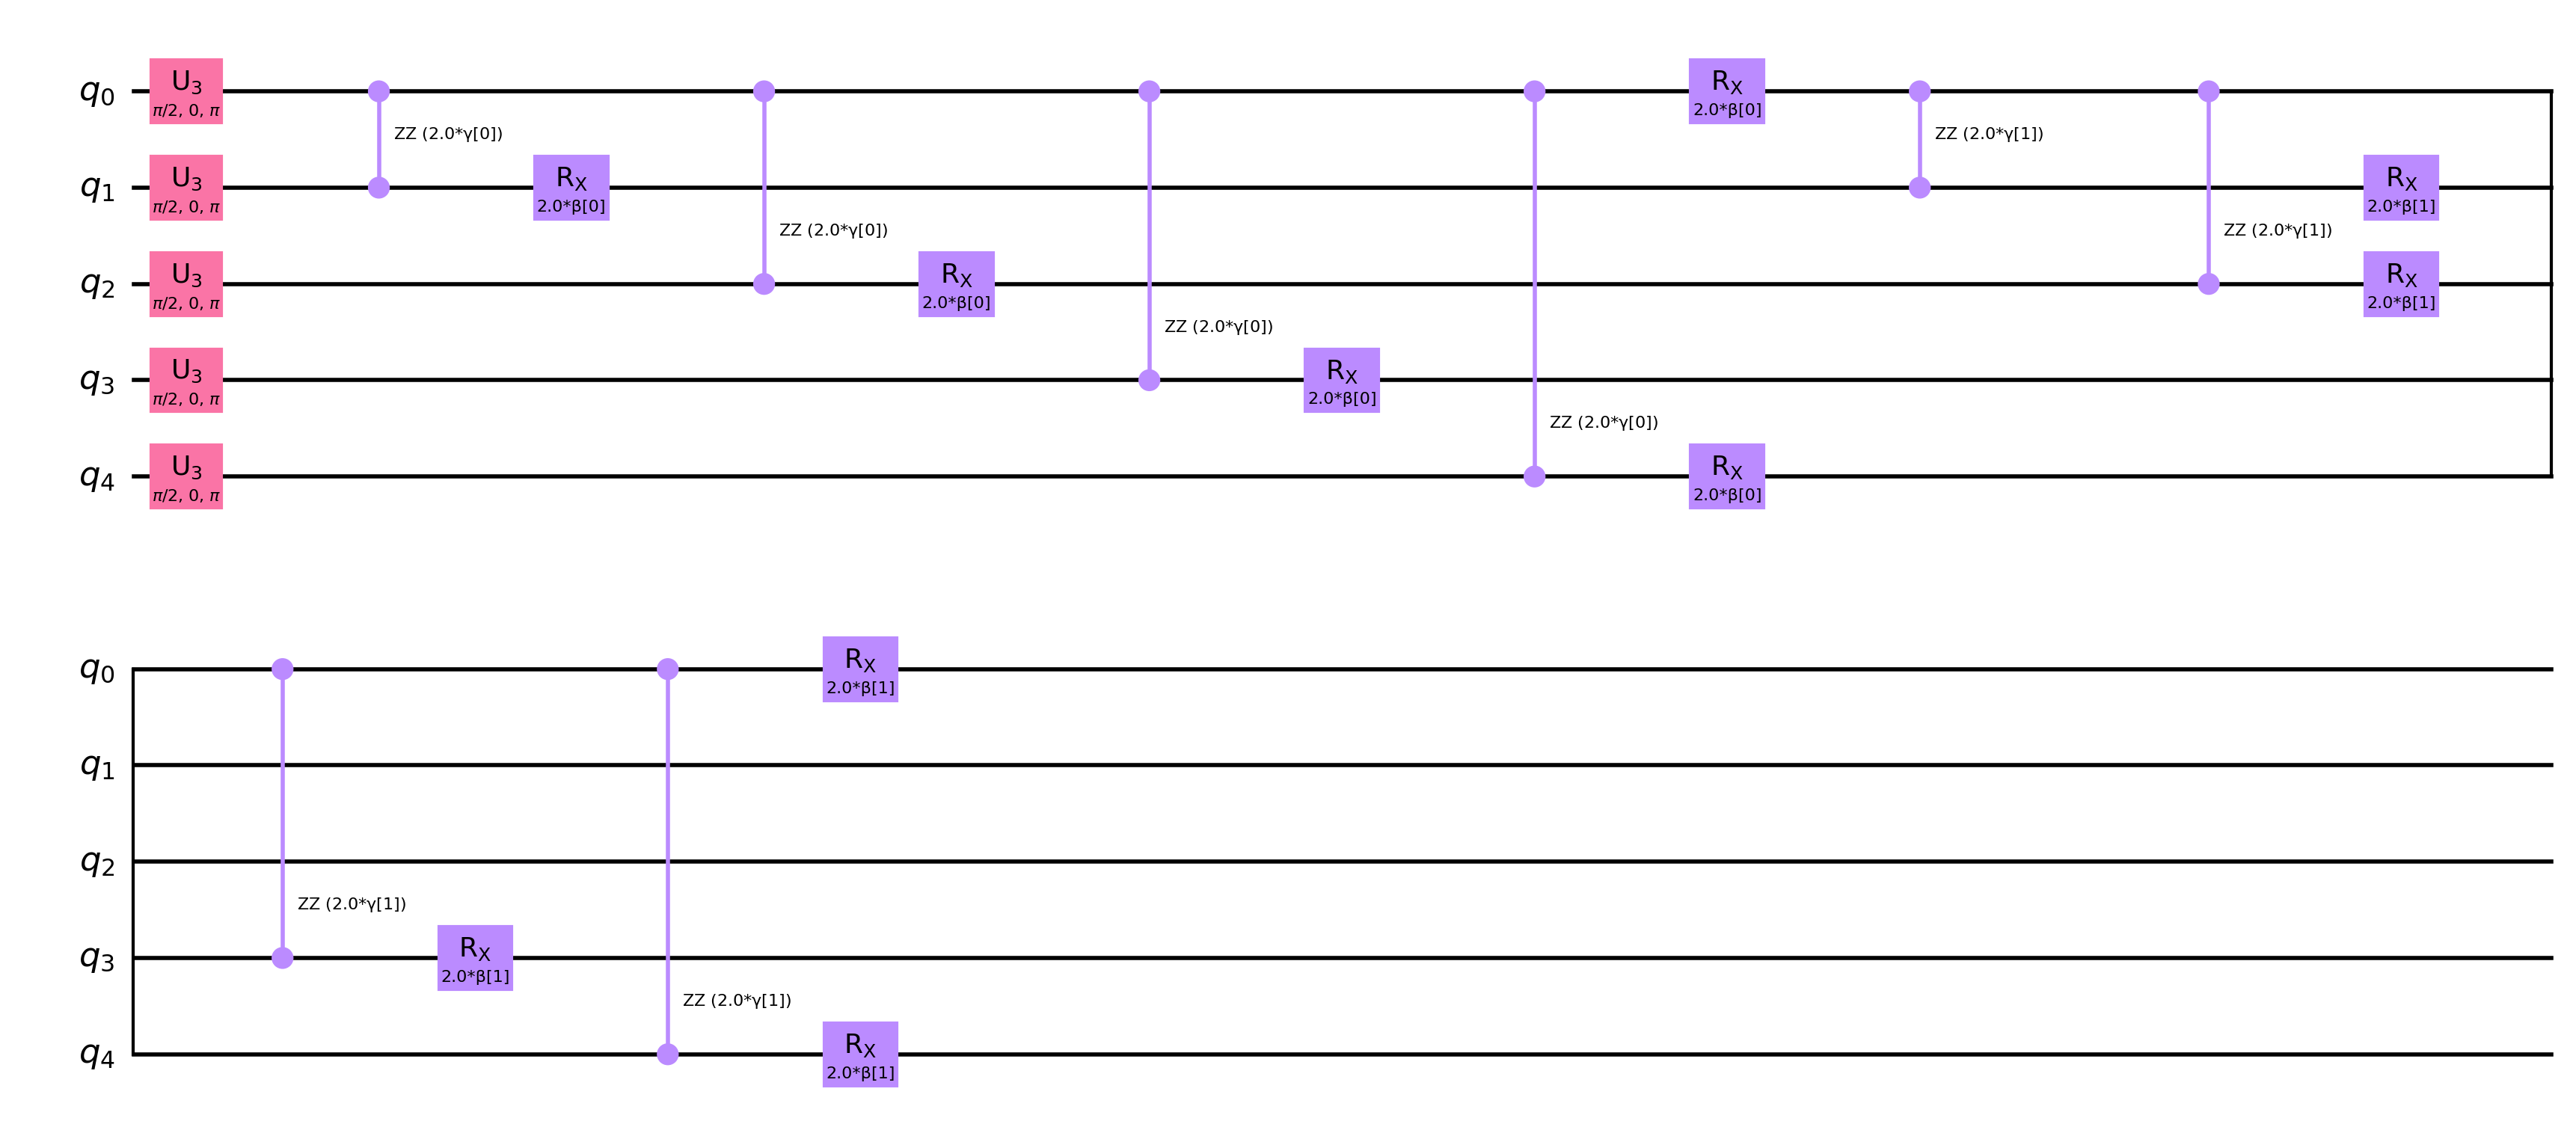

In [45]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

Above, we show the ansatz in basic gates for clarity. However, it can be expressed in multiple levels of decomposition by changing the `reps` argument or by drawing the circuit without the `decompose` method. For example, the following representation directly shows the QAOA structure with the default `reps` value, which is `reps=1`. 

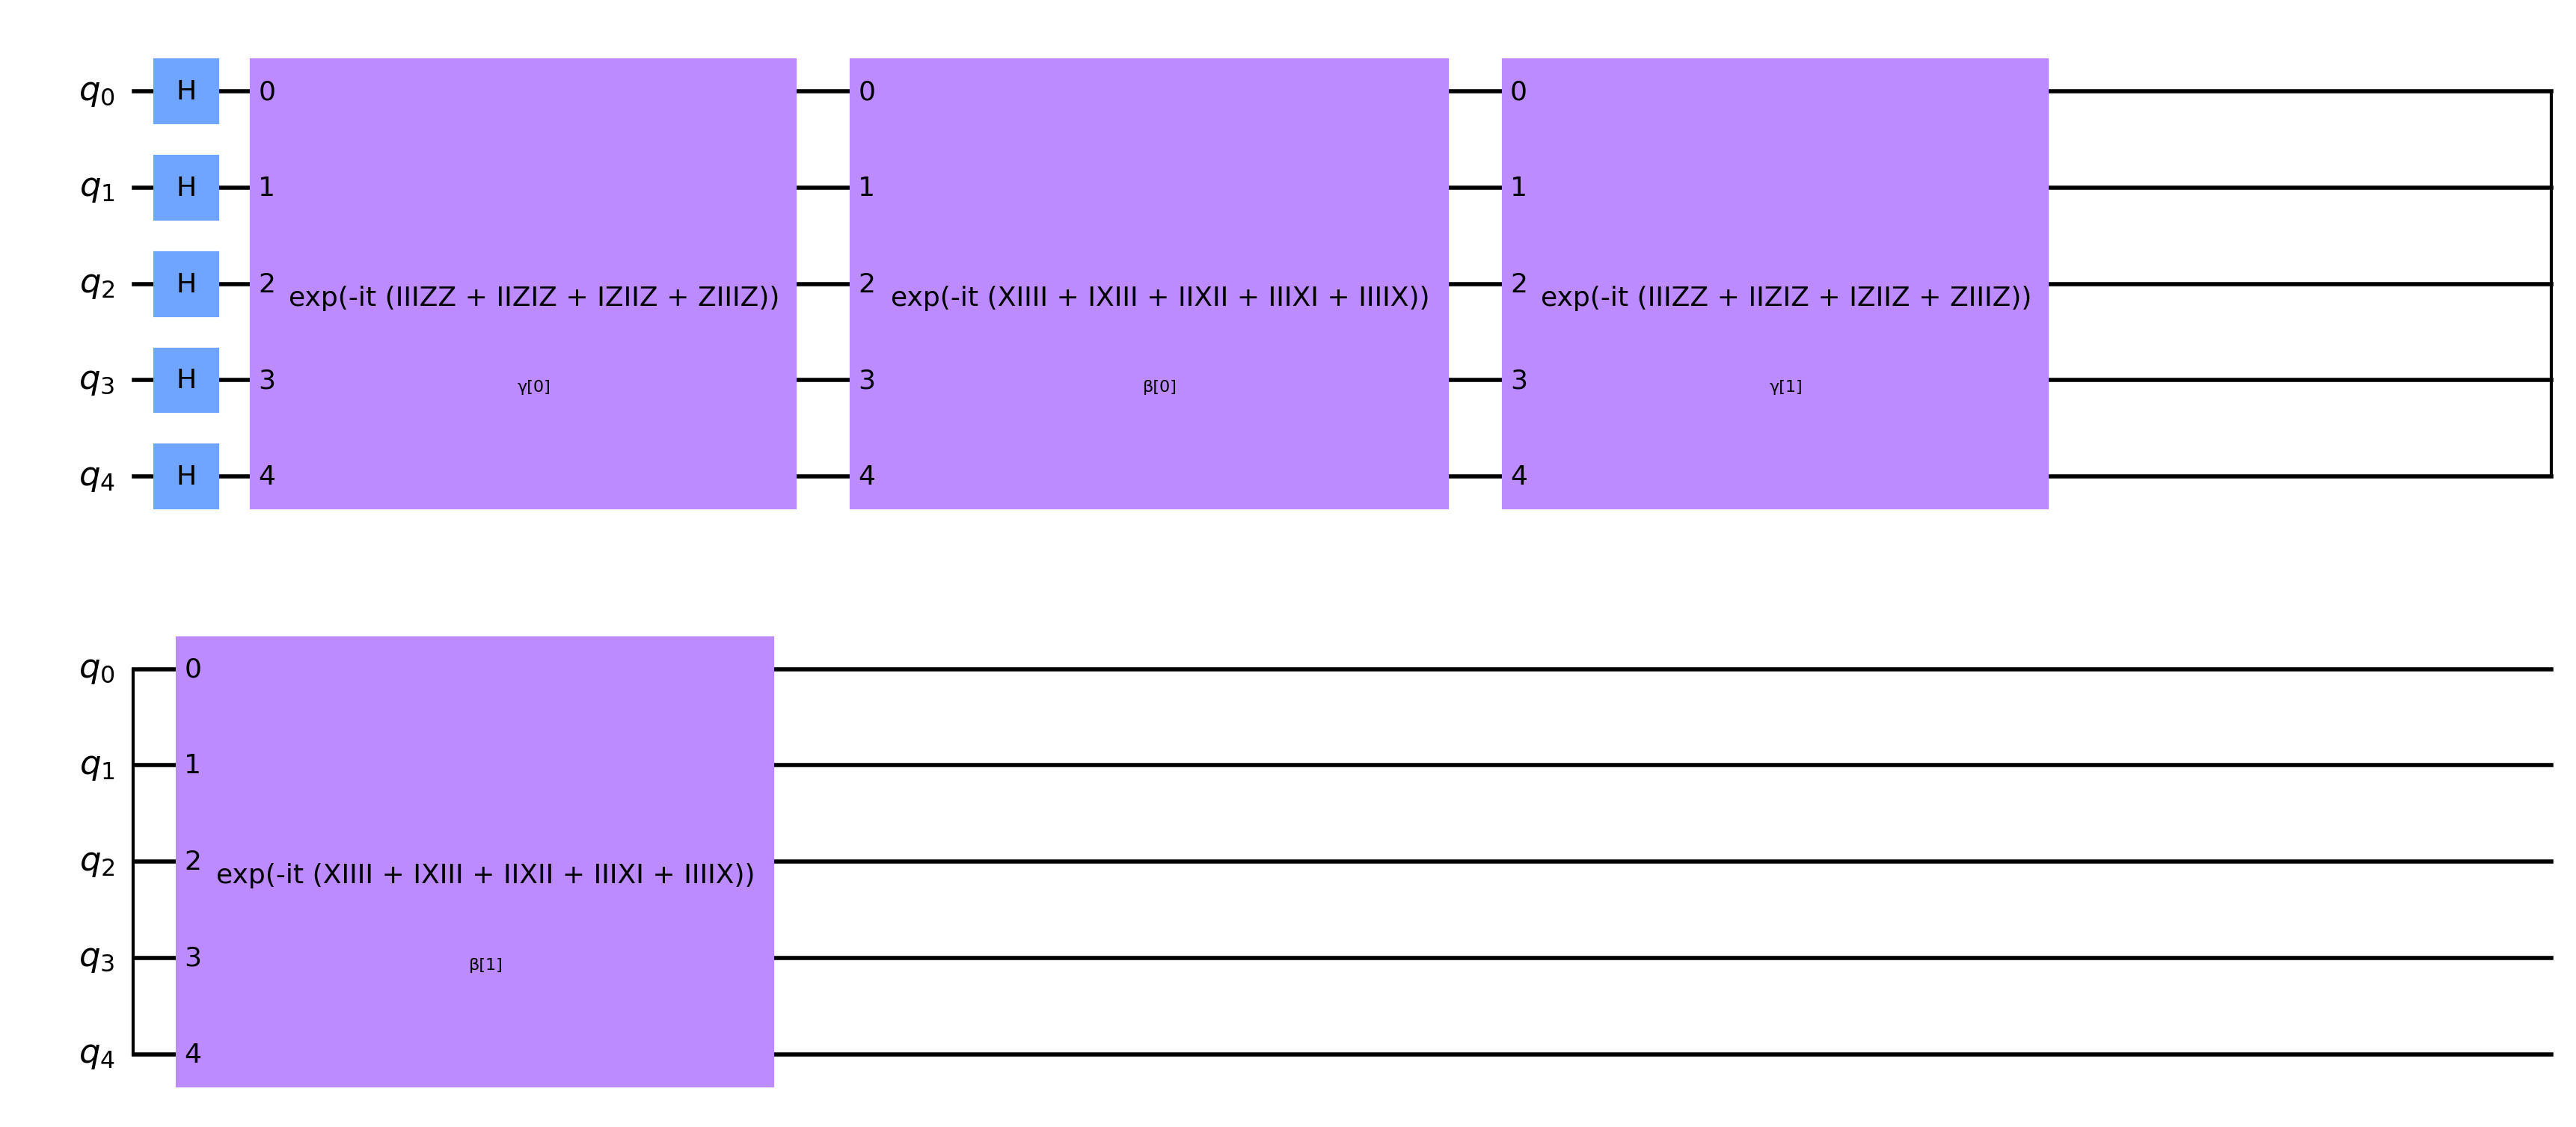

In [46]:
ansatz.decompose().draw("mpl")

## Define the cost function by using Estimator

As with an iterative optimization procedure, we now need to define our cost function over which to minimize.  We proceed in an identical manner to the [VQE tutorial](vqe_with_estimator.ipynb), computing the expectation value of our Hamiltonian with respect to the parameterized ansatz circuit using the Qiskit Runtime `Estimator` primitive:

In [47]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

## Minimize the cost function

Any classical optimizer can be used to minimize the cost function.  On a real quantum system, an optimizer designed for non-smooth cost function landscapes usually does better.  Here we use the [COBYLA routine from SciPy via the minimize function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

Because we are iteratively executing many calls to Runtime, we make use of a `Session` in order to execute all calls within a single block.  Moreover, for QAOA, the solution is encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization.  Therefore, we will need a `Sampler` primitive as well, and will instantiate it with the same `Session`.

In [48]:
session = Session(backend=backend)

estimator = Estimator(session=session, options={"shots": int(1e4)})
sampler = Sampler(session=session, options={"shots": int(1e4)})

We now set an initial set of random parameters:

In [50]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

and run our minimization routine:

In [64]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(obj_func_eval):
    clear_output(wait=True)
    # objective_func_vals.append(obj_func_eval)
    objective_func_vals = obj_func_eval
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(objective_func_vals)
    plt.show()

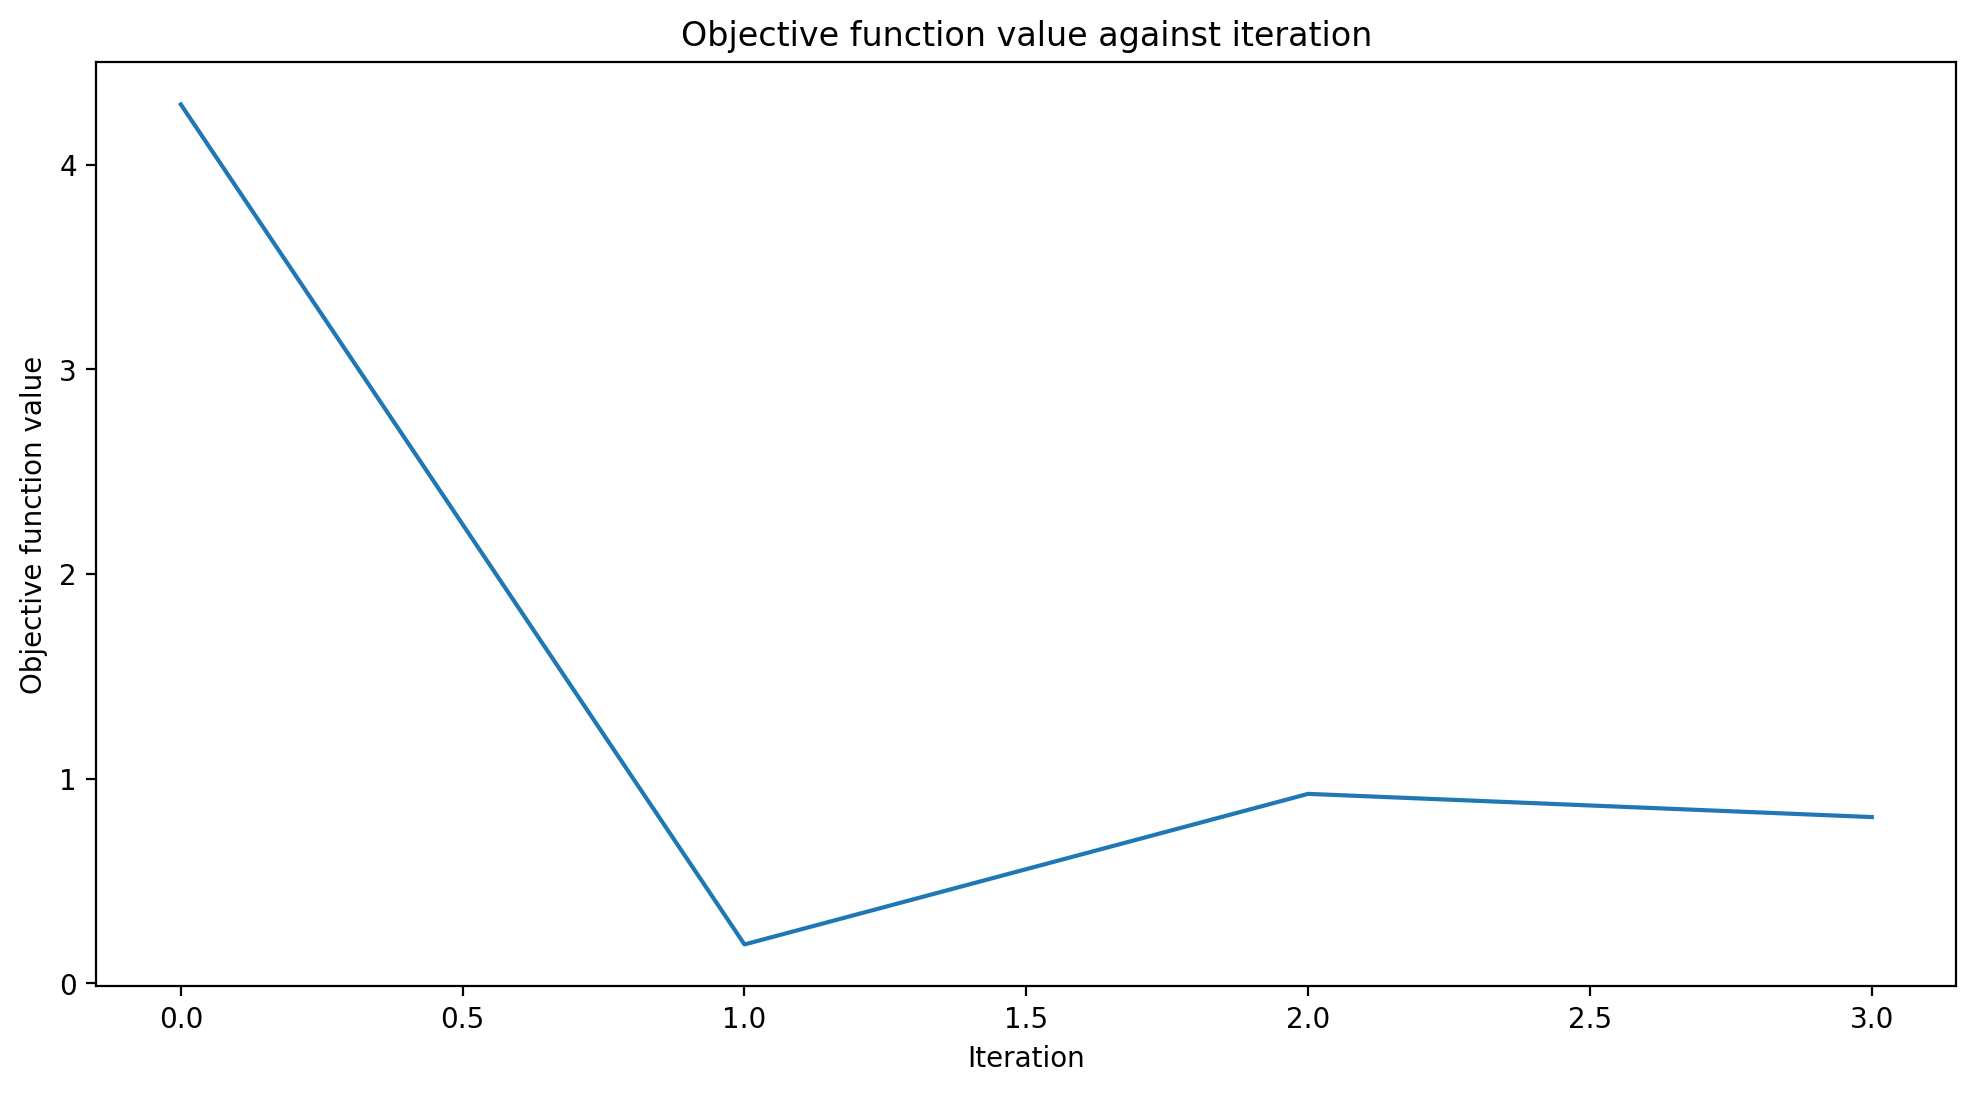

In [63]:
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA", callback=callback_graph)

In the end, we have a result in the standard SciPy `OptimizeResult` format.

In [65]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.3494
       x: [ 4.294e+00  1.908e-01  9.263e-01  8.130e-01]
    nfev: 51
   maxcv: 0.0

## Solution to max-cut

The solution vector of parameter angles (`x`), when plugged into the `ansatz` circuit, yields the graph partitioning that we were looking for.

In [66]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

In [67]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
session.close()

For small problem instances, the solution can be visually obtained:

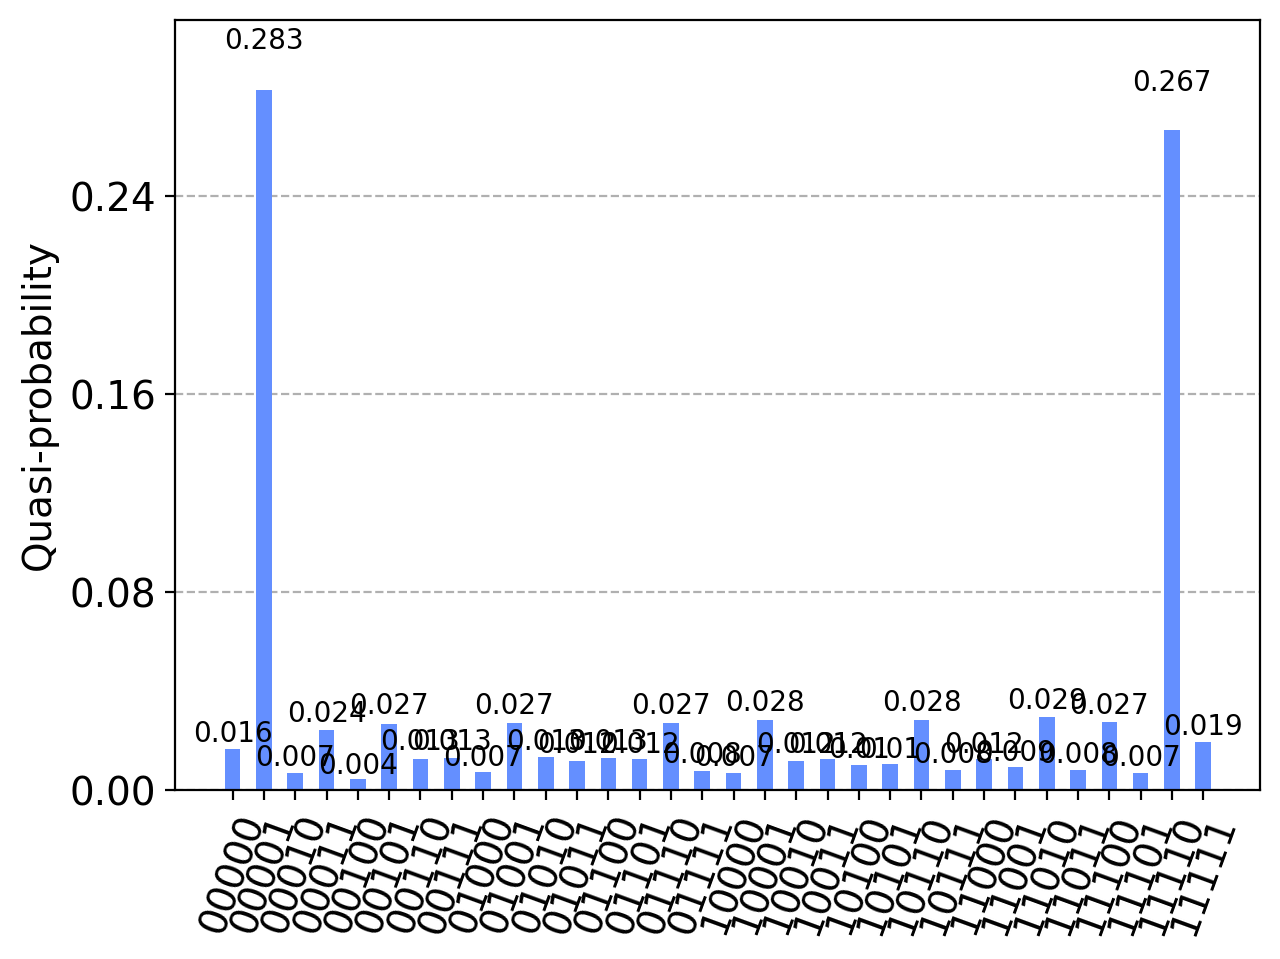

In [68]:
plot_distribution(samp_dist.binary_probabilities())

The most probable bit-strings, up to finite-sampling deviations, encode the solution.  Here we see that `00001` and `11110` are found, and are indeed correct.  There are two solutions because the labeling of the two partitions with `'0'` or `'1'` is arbitrary.

In [1]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.11.1'

In [1]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright